# Data z reálné jízdy (RSX-UM7)
### Zkoumání pro korelaci s realitou

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import tconsumption
from umparse import um_csv_parser, make_geojson
import matplotlib.pyplot as plt
from scipy.signal import hilbert, argrelextrema
import ruptures as rpt
import importlib
import os
from csv2geojson import prep
import json
from fastdtw import fastdtw

pd.options.mode.chained_assignment = None

### Načtení souboru se surovými daty

In [2]:
df = um_csv_parser("../testing-data/um7/um7capture_2023-09-29_06-26-06.csv") # Korekce pro začátek jízdy
df["accel_proc_y"] *= -1 # Korekce pro jízdní směr

# geojson = make_geojson(df["gps_latitude"], df["gps_longitude"])
# with open("/tmp/test.geojson", "w") as f:
#     f.write(geojson)

Index(['time', 'packet_type', 'gps_latitude', 'gps_longitude', 'gps_altitude',
       'gps_course', 'gps_speed', 'gps_time', 'gyro_proc_x', 'gyro_proc_y',
       'gyro_proc_z', 'gyro_proc_time', 'accel_proc_x', 'accel_proc_y',
       'accel_proc_z', 'accel_proc_time', 'mag_proc_x', 'mag_proc_y',
       'mag_proc_z', 'mag_proc_time', 'velocity_north', 'velocity_east',
       'velocity_up', 'velocity_time'],
      dtype='object')


### Náhled na akceleraci a rychlost v celém souboru

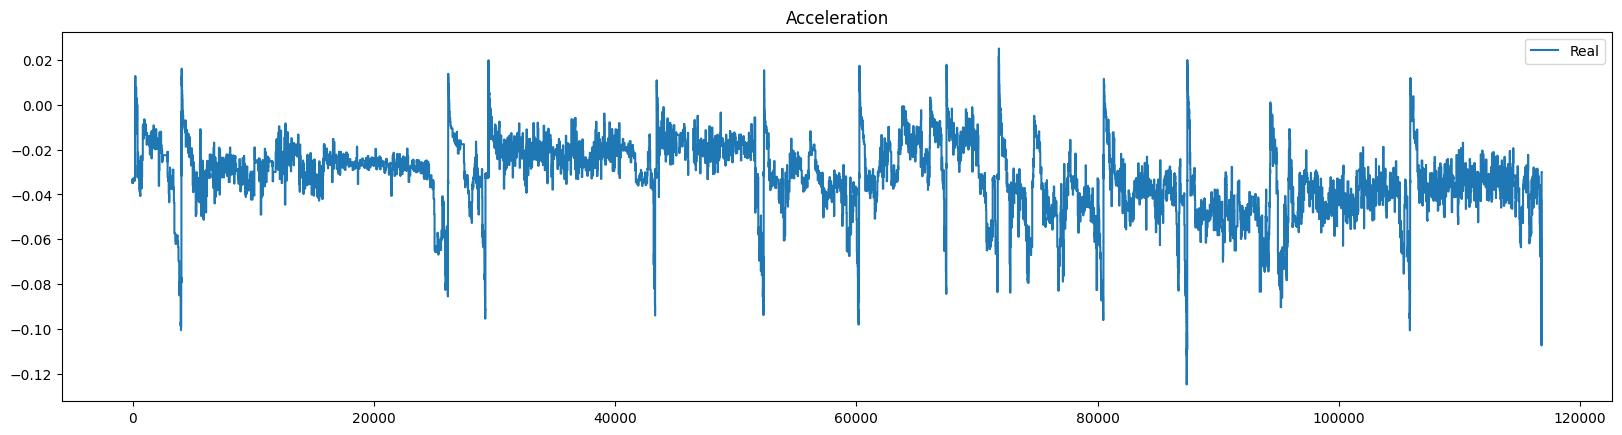

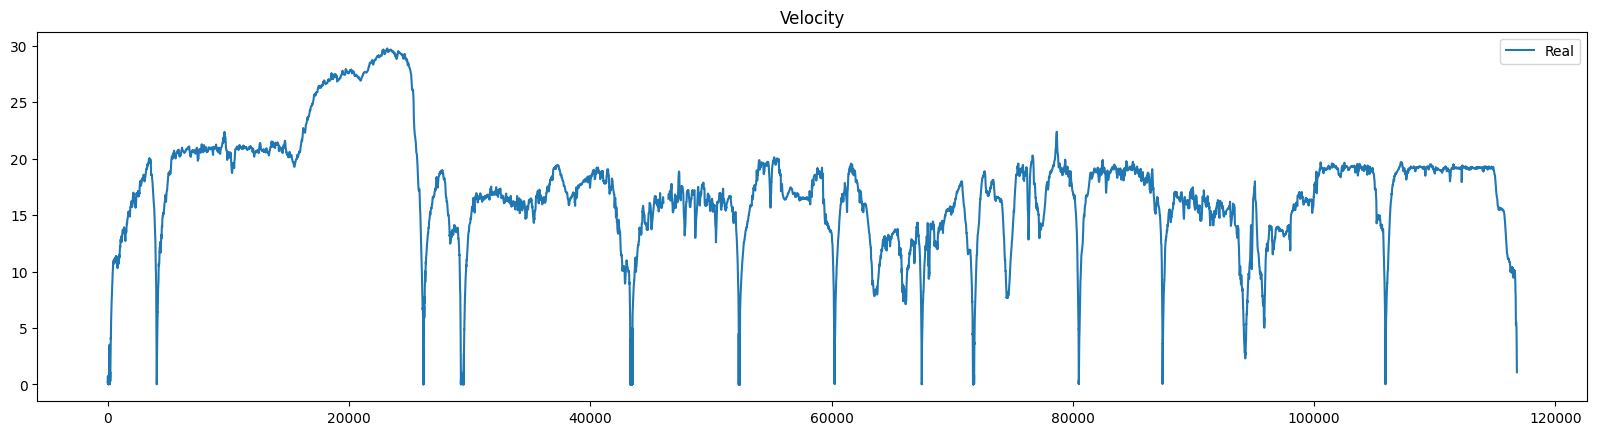

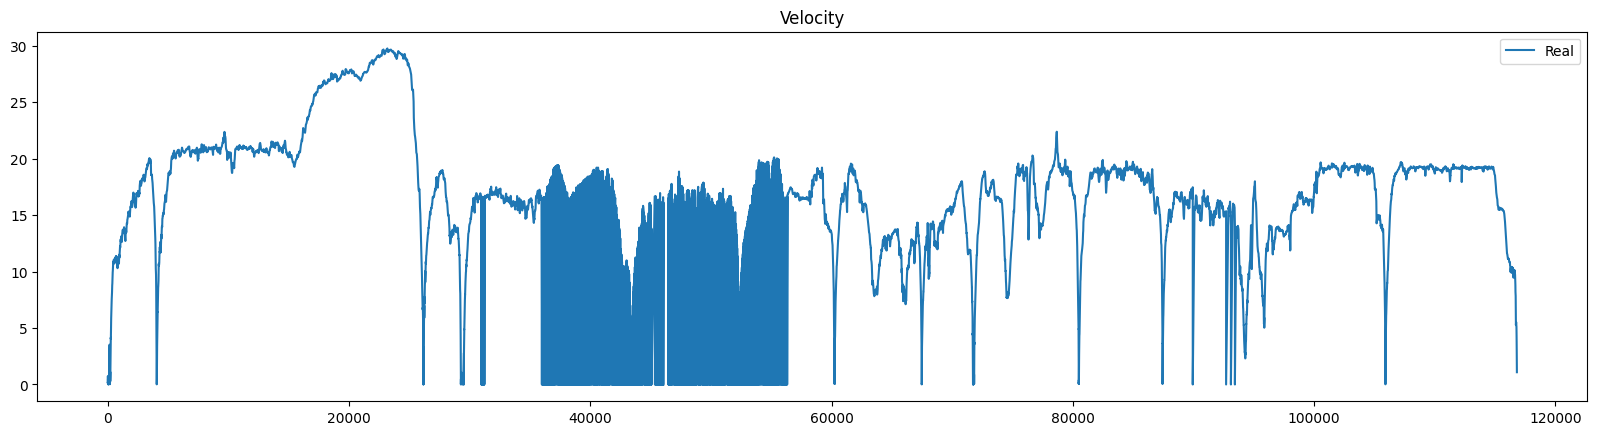

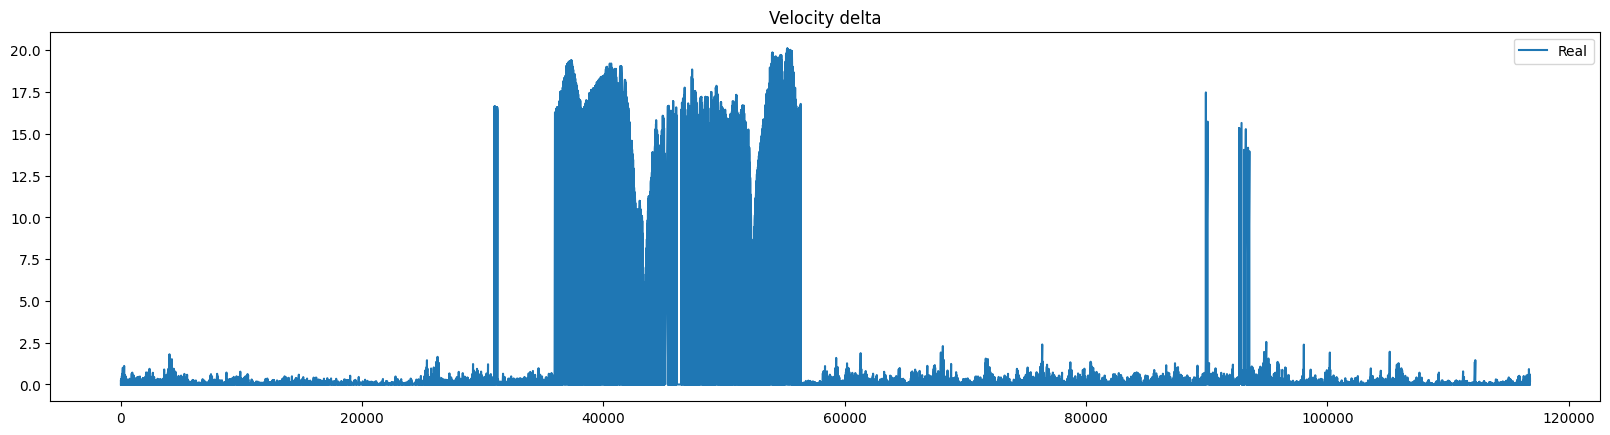

In [16]:
plt.figure().set_figwidth(20)
plt.plot(df["cumulative_distance_m"], df["accel_proc_y"])
plt.title("Acceleration")
plt.legend(["Real"], loc ="upper right")
plt.show()

plt.figure().set_figwidth(20)
plt.plot(df["cumulative_distance_m"], df["gps_speed"])
plt.title("Velocity")
plt.legend(["Real"], loc ="upper right")
plt.show()

plt.figure().set_figwidth(20)
plt.plot(df["cumulative_distance_m"], df["gps_speed_raw"])
plt.title("Velocity")
plt.legend(["Real"], loc ="upper right")
plt.show()

plt.figure().set_figwidth(20)
plt.plot(df["cumulative_distance_m"], df["gps_speed_delta"])
plt.title("Velocity delta")
plt.legend(["Real"], loc ="upper right")
plt.show()

### Funkce pro zpracování

In [4]:
def render_plot(title, x, ys, labels, width=20):
    plt.figure().set_figwidth(width)
    for y in ys:
        plt.plot(x, y)
    plt.title(title)
    if len(labels) > 0:
        plt.legend(labels, loc ="upper right")
    plt.show()

In [5]:
def map_velocity(df_measured, first_offset, velocity_fp):
    with open(velocity_fp) as f:
        track_velocity = json.load(f)["velocity"]

    first_dist = df_measured["cumulative_distance_m"].iloc[0]
    for tv in track_velocity:
        start_in_m = tv["start"]*1000
        df_measured.loc[first_offset*1000 - (df_measured["cumulative_distance_m"]-first_dist) <= start_in_m, "track_velocity"] = tv["value"]

    df_measured["track_velocity_m_s"] = df_measured["track_velocity"]/3.6

In [6]:
def compare_data(df_measured, geojson_path: str):
    # # Data identification
    # data_name = os.path.basename(geojson_path).split(".")[0]

    # Calculated data
    c = tconsumption.Consumption()
    c.variable_params = {
        "Elevation smoothing": 100,
        "Curve smoothing": 10,
        "Curve A": 165.4719097490903,
        "Curve B": 79.29357669377308,
        "Running a": 0.9584966779395766,
        "Running b": 0.055049187454079364,
        "Running c": 0.008098225496258339,
        "Recuperation coefficient": 0.112068236581338,
        "Comfortable acceleration": 0.29713292834183425
    }
    c.load_from_file(geojson_path)
    c.max_velocities_in_mps = list(df_measured["track_velocity_m_s"])
    print("unique velocities in km/h", set([x*3.6 for x in df_measured["track_velocity_m_s"]]))

    # Modifying some parameters (source: https://cs.wikipedia.org/wiki/Motorov%C3%BD_v%C5%AFz_860)
    c.params["power_limit"] = 480*1000
    c.params["mass_locomotive"] = 56000
    c.params["mass_wagon"] = 31490 + 33000

    # Running the simulation
    c.run()

    # Plotting
    render_plot("Elevation", c.series["dist_values"], [[x[2] for x in c.points]], [])

    render_plot(
        "Velocity",
        c.series["dist_values"],
        [c.series["velocity_values"], df_measured["gps_speed"], c.max_velocities_in_mps],
        ["Simulation", "Real", "Limit"]
    )

    render_plot(
        "Acceleration",
        c.series["dist_values"],
        [df_measured["accel_proc_y"]],
        ["Real"]
    )

    render_plot(
        "Acceleration",
        c.series["dist_values"],
        [c.series["acceleration_values"]],
        ["Simulation"]
    )

    dtw = fastdtw(c.series["velocity_values"], df_measured["gps_speed"])[0]
    print("DTW:", dtw)

    # render_plot(
    #     "Acceleration",
    #     c.series["dist_values"][:100],
    #     [c.series["acceleration_values"][:100]],
    #     ["Simulation (slice)"]
    # )

### Opava západ --> Krnov-Cvilín
> Vybrání části k sledování a předzpracování

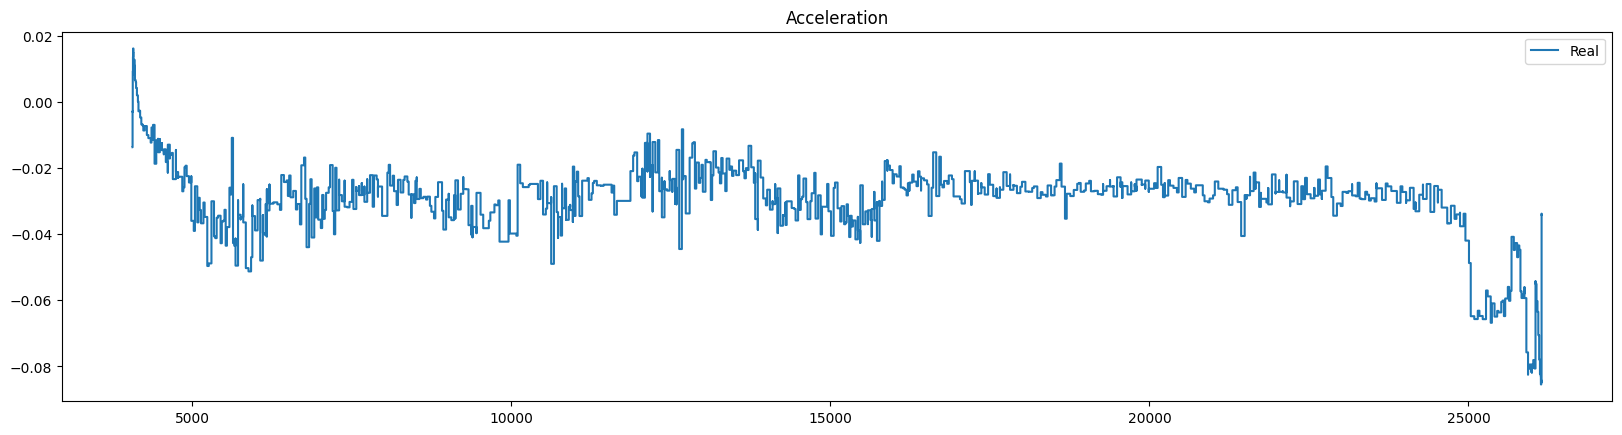

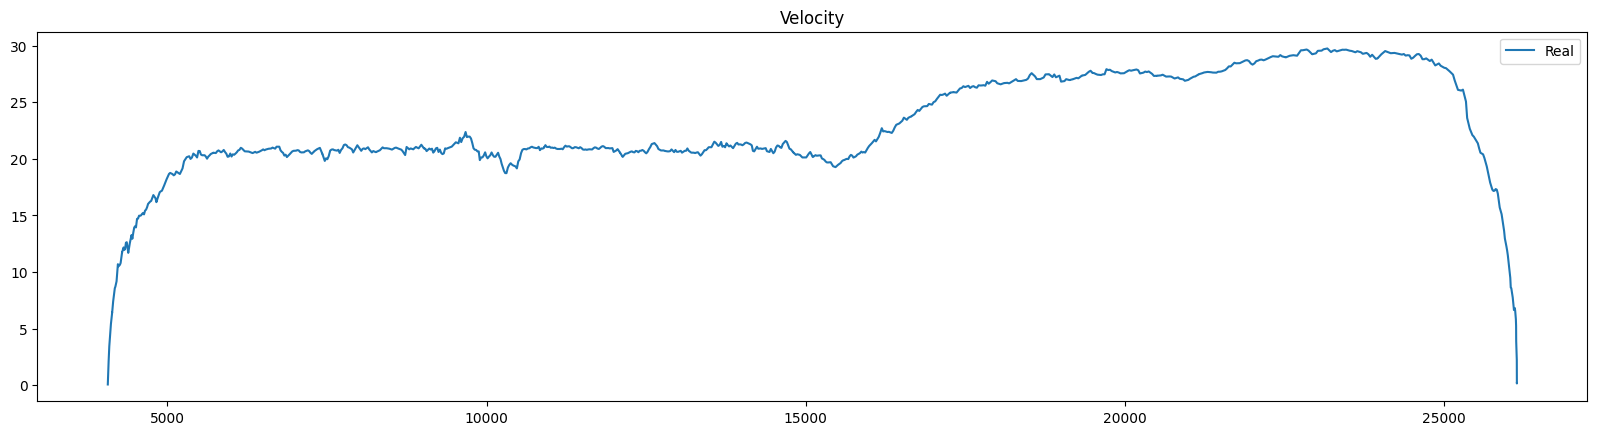

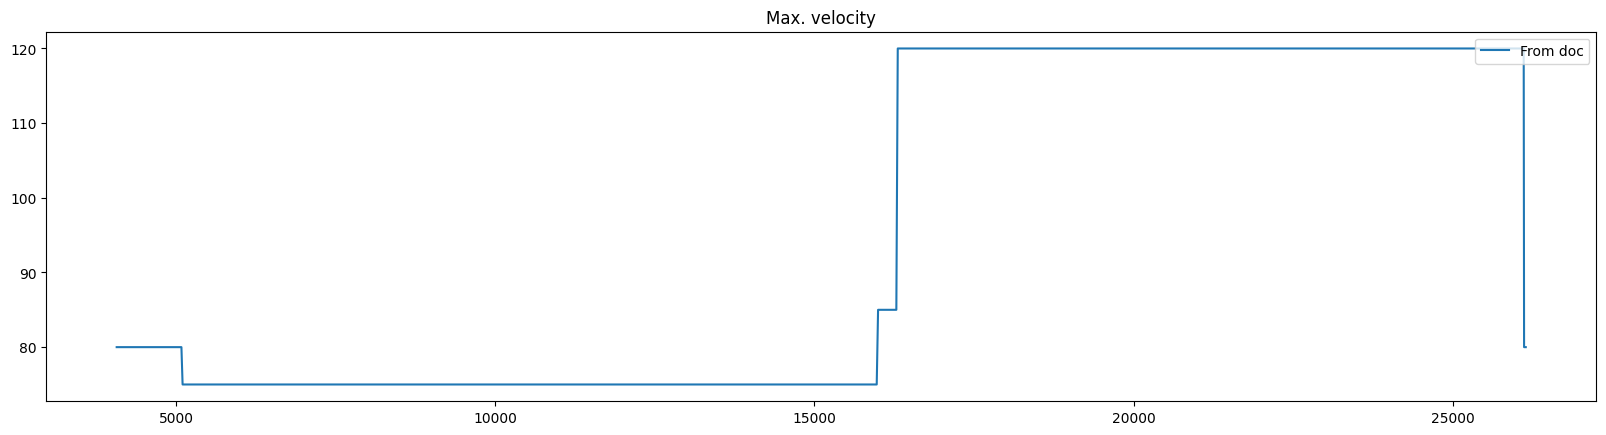

In [7]:
df_slice = df.loc[1080:3530] # Rozsah bodů mezi stanicemi

map_velocity(df_slice, 112.329, "../testing-data/velocity-data/310-pj.json")

# Plots
render_plot("Acceleration", df_slice["cumulative_distance_m"], [df_slice["accel_proc_y"]], ["Real"])
render_plot("Velocity", df_slice["cumulative_distance_m"], [df_slice["gps_speed"]], ["Real"])
render_plot("Max. velocity", df_slice["cumulative_distance_m"], [df_slice["track_velocity"]], ["From doc"])

In [8]:
prep({
    # "input": "NOT NEEDED",
    "output": "../testing-data/um7/um7capture_2023-09-29_06-26-06_opava-krnov.geojson",
    "host": "localhost",
    "dbname": "railway_mapdb",
    "dbuser": "postgres",
    "dbpass": "mysecretpassword",
    "dbtable": "train_testing_data"
}, df=df_slice)

ERROR 1: libcfitsio.so.10: cannot open shared object file: No such file or directory
ERROR 1: libcfitsio.so.10: cannot open shared object file: No such file or directory
ERROR 1: libhdf5.so.310: cannot open shared object file: No such file or directory
ERROR 1: libhdf5.so.310: cannot open shared object file: No such file or directory
ERROR 1: libpodofo.so.0.9.8: cannot open shared object file: No such file or directory
ERROR 1: libpodofo.so.0.9.8: cannot open shared object file: No such file or directory
ERROR 1: libnetcdf.so.19: cannot open shared object file: No such file or directory
ERROR 1: libnetcdf.so.19: cannot open shared object file: No such file or directory
ERROR 1: libarrow.so.1300: cannot open shared object file: No such file or directory
ERROR 1: libarrow.so.1300: cannot open shared object file: No such file or directory
ERROR 1: libmariadb.so.3: cannot open shared object file: No such file or directory
ERROR 1: libmariadb.so.3: cannot open shared object file: No such fi

unique velocities in km/h {80.0, 75.0, 120.00000000000001, 85.0}


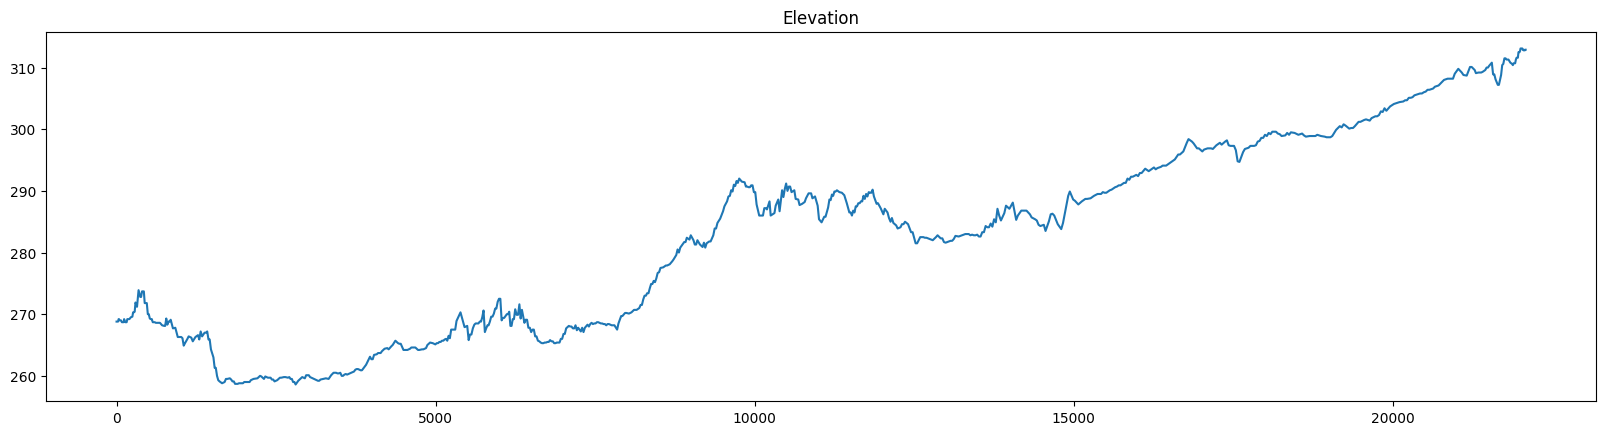

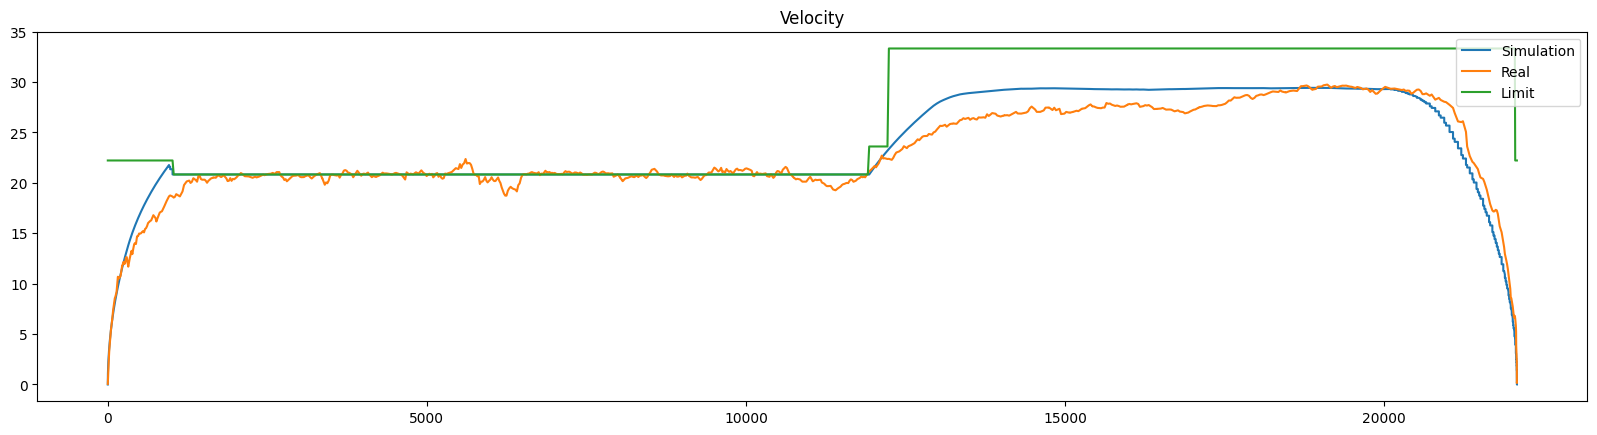

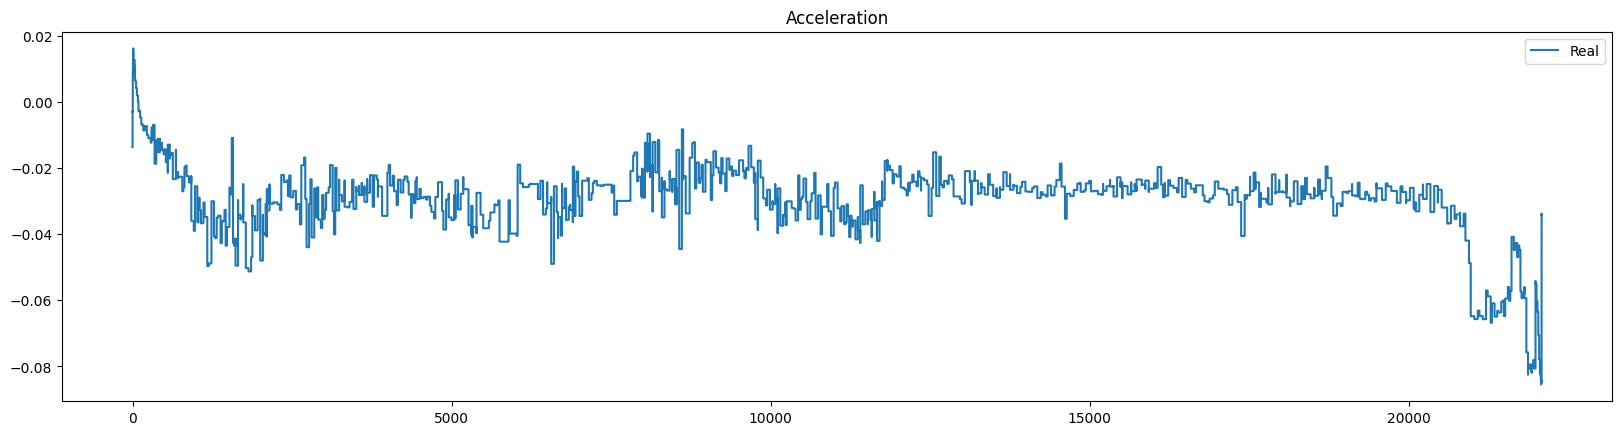

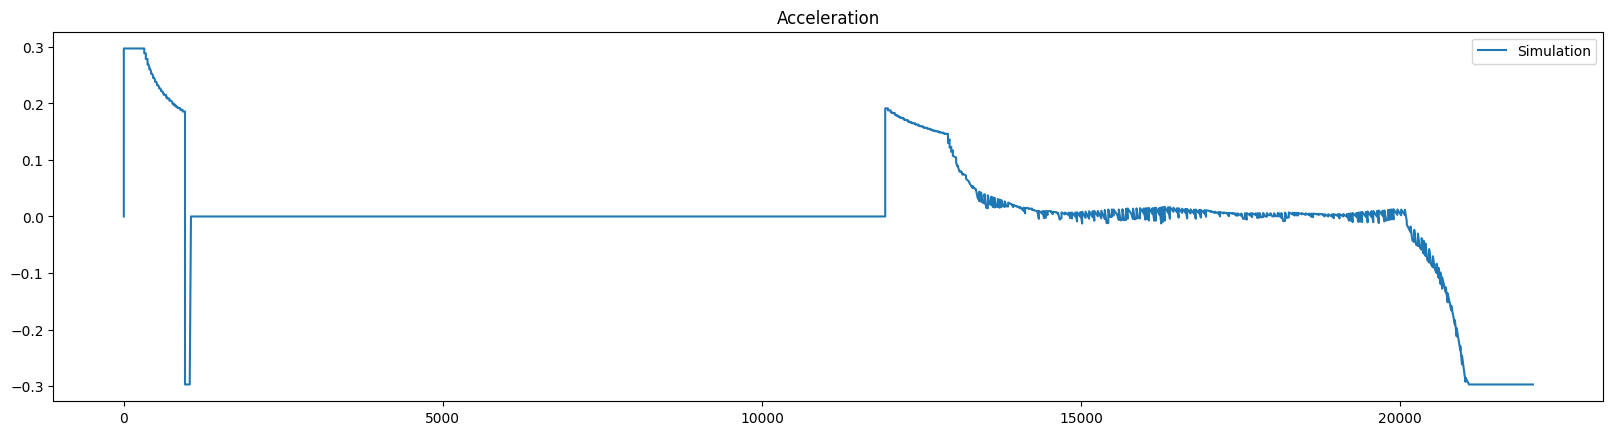

DTW: 603.8925899591128


In [9]:
importlib.reload(tconsumption)

compare_data(
    df_slice,
    "../testing-data/um7/um7capture_2023-09-29_06-26-06_opava-krnov.geojson"
)

### Krnov-Cvilín --> Krnov
> Vybrání části k sledování a předzpracování

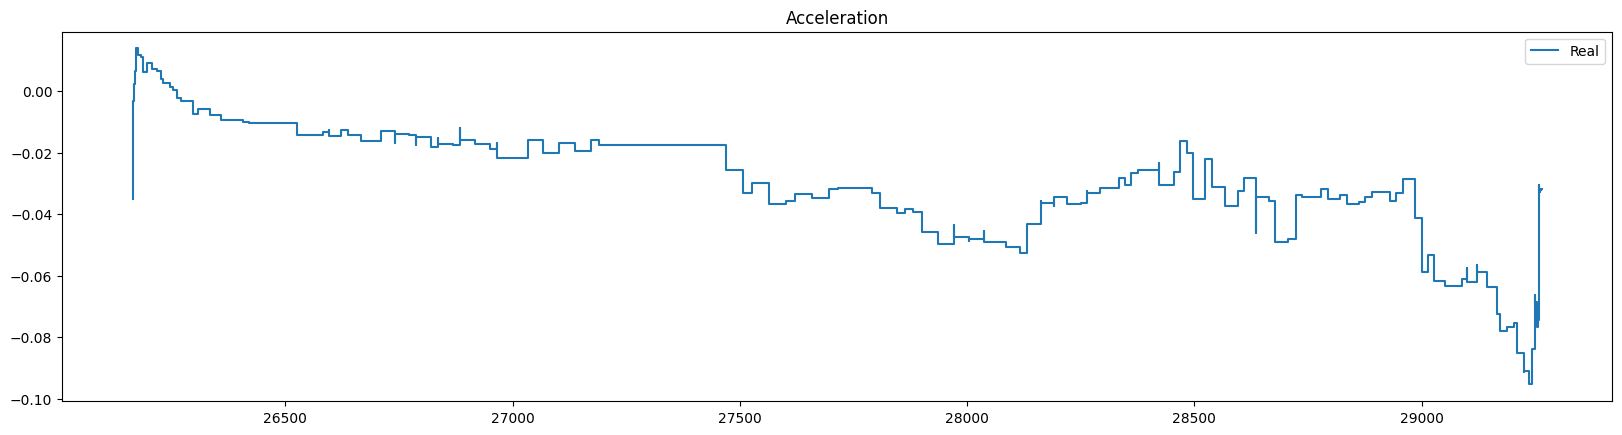

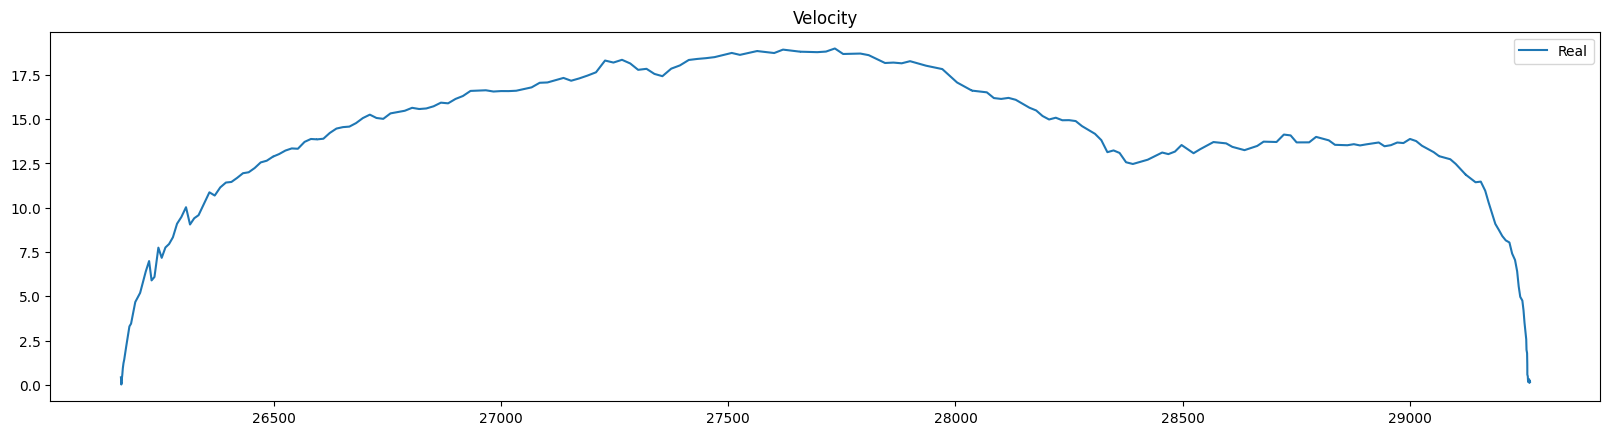

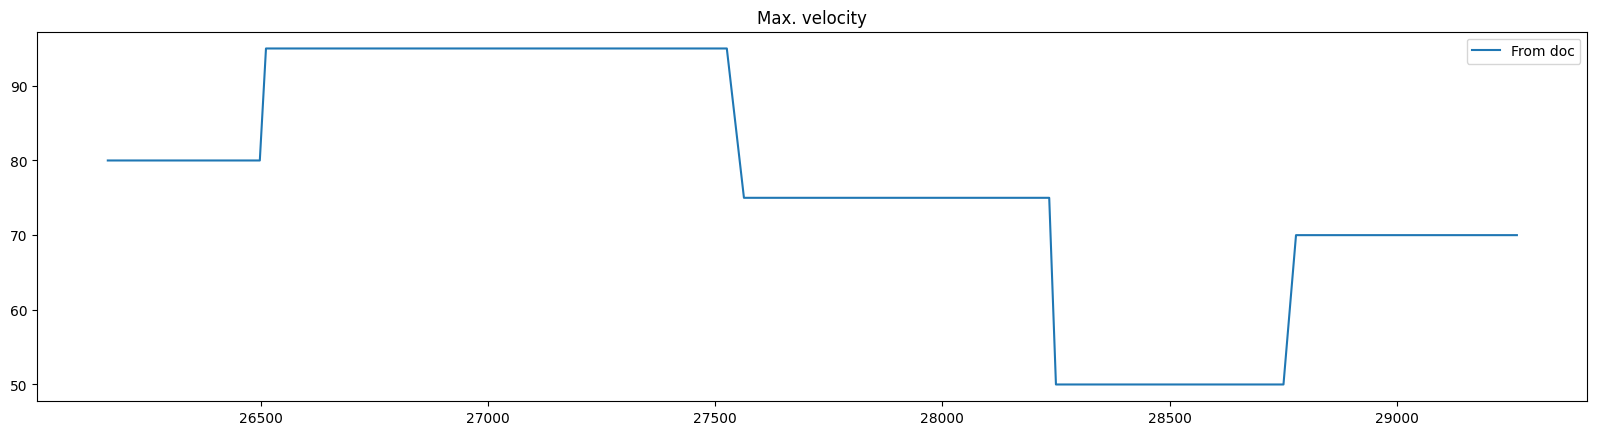

In [10]:
df_slice = df.loc[3680:4280] # Rozsah bodů mezi stanicemi

map_velocity(df_slice, 90.213, "../testing-data/velocity-data/310-pj.json")

render_plot("Acceleration", df_slice["cumulative_distance_m"], [df_slice["accel_proc_y"]], ["Real"])
render_plot("Velocity", df_slice["cumulative_distance_m"], [df_slice["gps_speed"]], ["Real"])
render_plot("Max. velocity", df_slice["cumulative_distance_m"], [df_slice["track_velocity"]], ["From doc"])

In [11]:
prep({
    # "input": "NOT NEEDED",
    "output": "../testing-data/um7/um7capture_2023-09-29_06-26-06_krnov-krnov.geojson",
    "host": "localhost",
    "dbname": "railway_mapdb",
    "dbuser": "postgres",
    "dbpass": "mysecretpassword",
    "dbtable": "train_testing_data"
}, df=df_slice)

ERROR 1: libcfitsio.so.10: cannot open shared object file: No such file or directory
ERROR 1: libcfitsio.so.10: cannot open shared object file: No such file or directory
ERROR 1: libhdf5.so.310: cannot open shared object file: No such file or directory
ERROR 1: libhdf5.so.310: cannot open shared object file: No such file or directory
ERROR 1: libpodofo.so.0.9.8: cannot open shared object file: No such file or directory
ERROR 1: libpodofo.so.0.9.8: cannot open shared object file: No such file or directory
ERROR 1: libnetcdf.so.19: cannot open shared object file: No such file or directory
ERROR 1: libnetcdf.so.19: cannot open shared object file: No such file or directory
ERROR 1: libarrow.so.1300: cannot open shared object file: No such file or directory
ERROR 1: libarrow.so.1300: cannot open shared object file: No such file or directory
ERROR 1: libmariadb.so.3: cannot open shared object file: No such file or directory
ERROR 1: libmariadb.so.3: cannot open shared object file: No such fi

unique velocities in km/h {70.0, 75.0, 80.0, 50.0, 95.0}


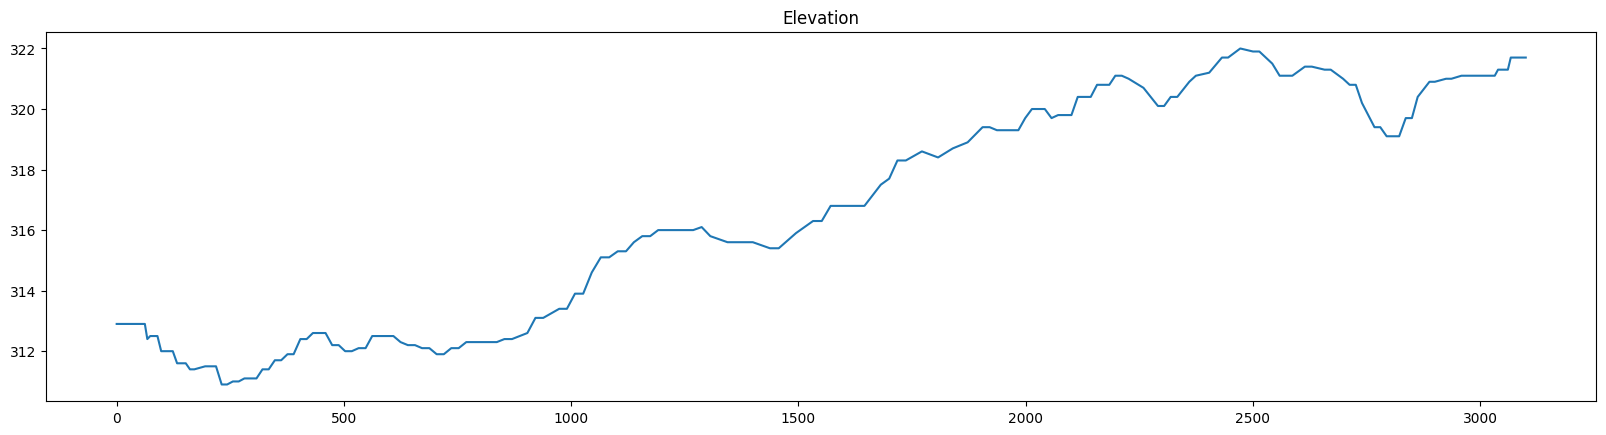

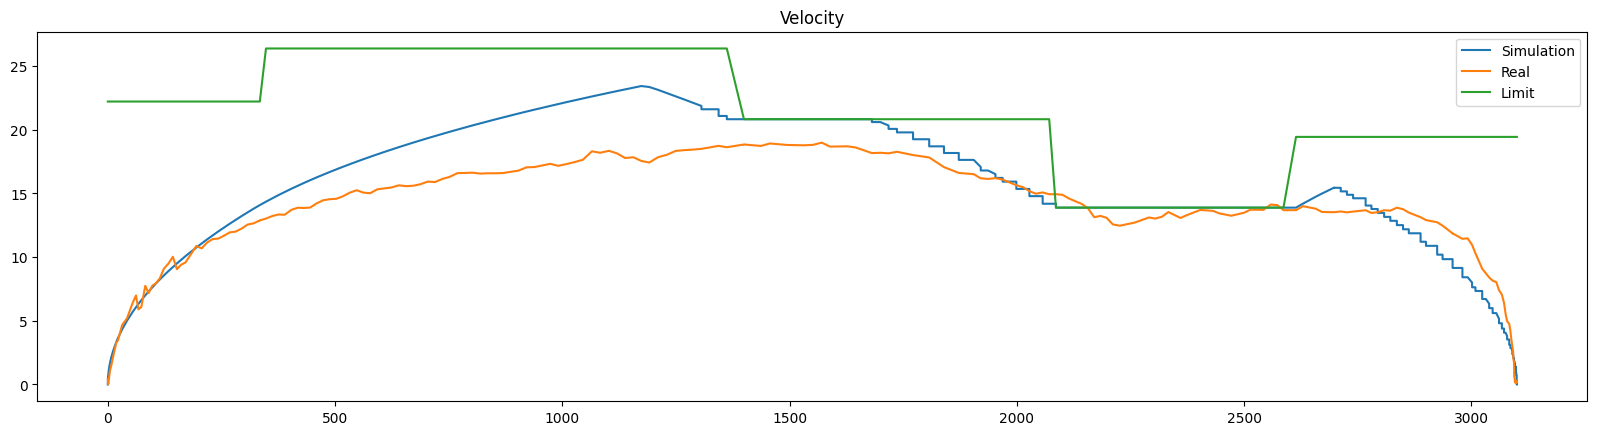

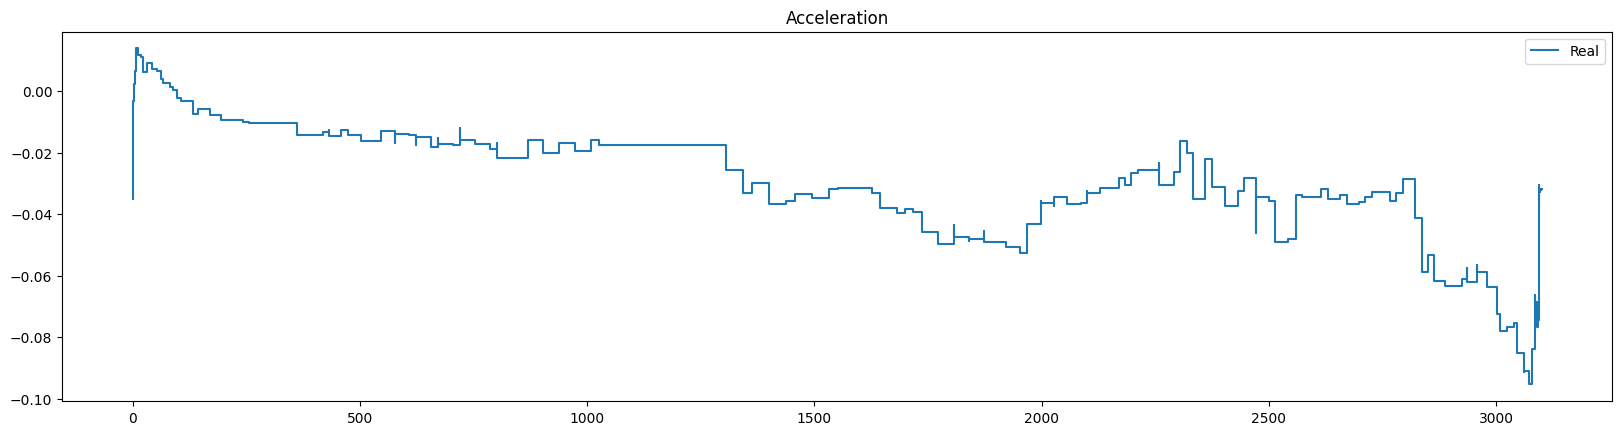

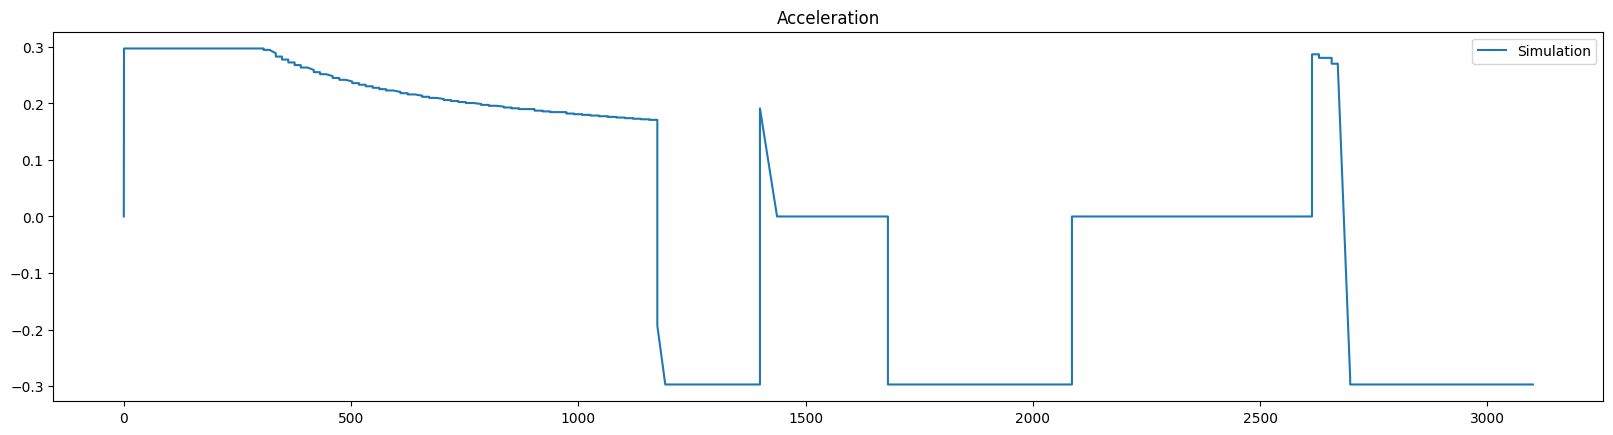

DTW: 459.7611515598653


In [12]:
importlib.reload(tconsumption)

compare_data(
    df_slice,
    "../testing-data/um7/um7capture_2023-09-29_06-26-06_krnov-krnov.geojson"
)

### Krnov --> Milotice n.Opavou
> Vybrání části k sledování a předzpracování

16.928890228271484
16.928890228271484
16.928890228271484
16.928890228271484
16.39583396911621
16.39583396911621
16.578487396240234
16.57833480834961
16.57833480834961
16.57833480834961
16.57833480834961
16.74361228942871
16.74361228942871
16.121145248413086
16.121389389038086
16.121389389038086
16.121389389038086
16.238332748413086
16.314167022705078
16.314167022705078
16.314167022705078
16.394445419311523
16.394445419311523
16.394445419311523
16.394445419311523
16.598548889160156
16.59861183166504
16.59861183166504
16.59861183166504
16.59861183166504
16.55379295349121
16.553611755371094
16.553611755371094
16.553611755371094
16.553611755371094
16.525001525878906
16.525001525878906
16.525001525878906
16.525001525878906
16.460556030273438
16.44444465637207
16.44444465637207
16.45965003967285
16.4597225189209
16.925735473632812
16.925735473632812
16.925735473632812
16.771390914916992
16.771390914916992
16.771390914916992
16.660554885864258
16.660554885864258
16.675277709960938
16.67527770

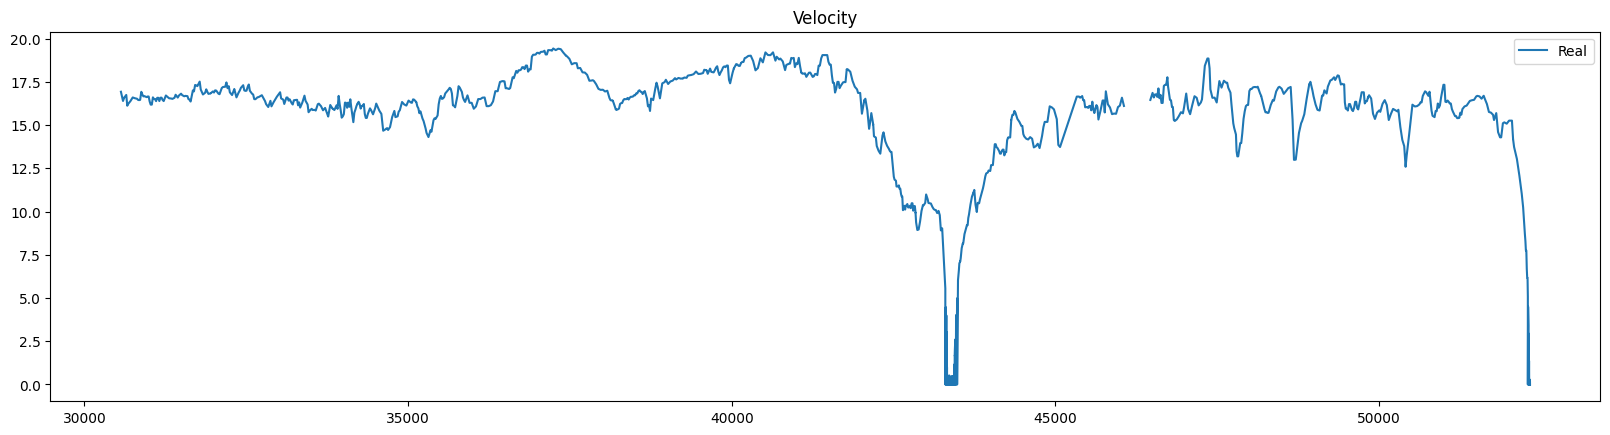

In [13]:
# 4280
df_slice = df.loc[5800:10000] # Rozsah bodů mezi stanicemi

map_velocity(df_slice, 0, "../testing-data/velocity-data/310-pj.json")

for x in df_slice["gps_speed"]:
    print(x)

# render_plot("Acceleration", df_slice["cumulative_distance_m"], [df_slice["accel_proc_y"]], ["Real"])
render_plot("Velocity", df_slice["cumulative_distance_m"], [df_slice["gps_speed"]], ["Real"])
# render_plot("Max. velocity", df_slice["cumulative_distance_m"], [df_slice["track_velocity"]], ["From doc"])

In [14]:
prep({
    # "input": "NOT NEEDED",
    "output": "../testing-data/um7/um7capture_2023-09-29_06-26-06_krnov-krnov.geojson",
    "host": "localhost",
    "dbname": "railway_mapdb",
    "dbuser": "postgres",
    "dbpass": "mysecretpassword",
    "dbtable": "train_testing_data"
}, df=df_slice)

ERROR 1: libcfitsio.so.10: cannot open shared object file: No such file or directory
ERROR 1: libcfitsio.so.10: cannot open shared object file: No such file or directory
ERROR 1: libhdf5.so.310: cannot open shared object file: No such file or directory
ERROR 1: libhdf5.so.310: cannot open shared object file: No such file or directory
ERROR 1: libpodofo.so.0.9.8: cannot open shared object file: No such file or directory
ERROR 1: libpodofo.so.0.9.8: cannot open shared object file: No such file or directory
ERROR 1: libnetcdf.so.19: cannot open shared object file: No such file or directory
ERROR 1: libnetcdf.so.19: cannot open shared object file: No such file or directory
ERROR 1: libarrow.so.1300: cannot open shared object file: No such file or directory
ERROR 1: libarrow.so.1300: cannot open shared object file: No such file or directory
ERROR 1: libmariadb.so.3: cannot open shared object file: No such file or directory
ERROR 1: libmariadb.so.3: cannot open shared object file: No such fi

unique velocities in km/h {40.0}


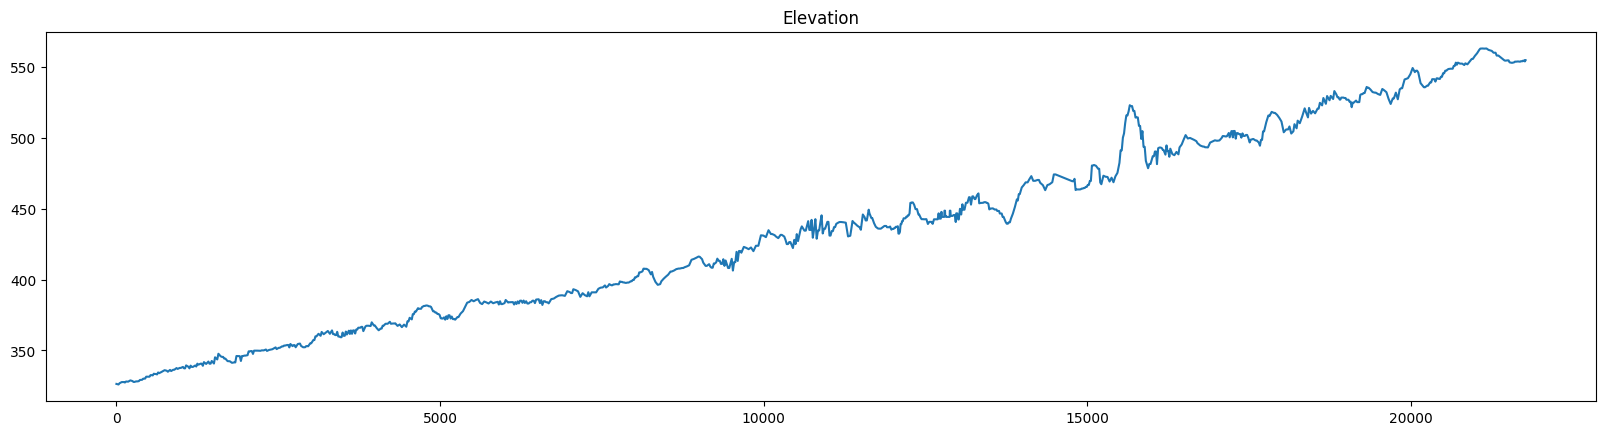

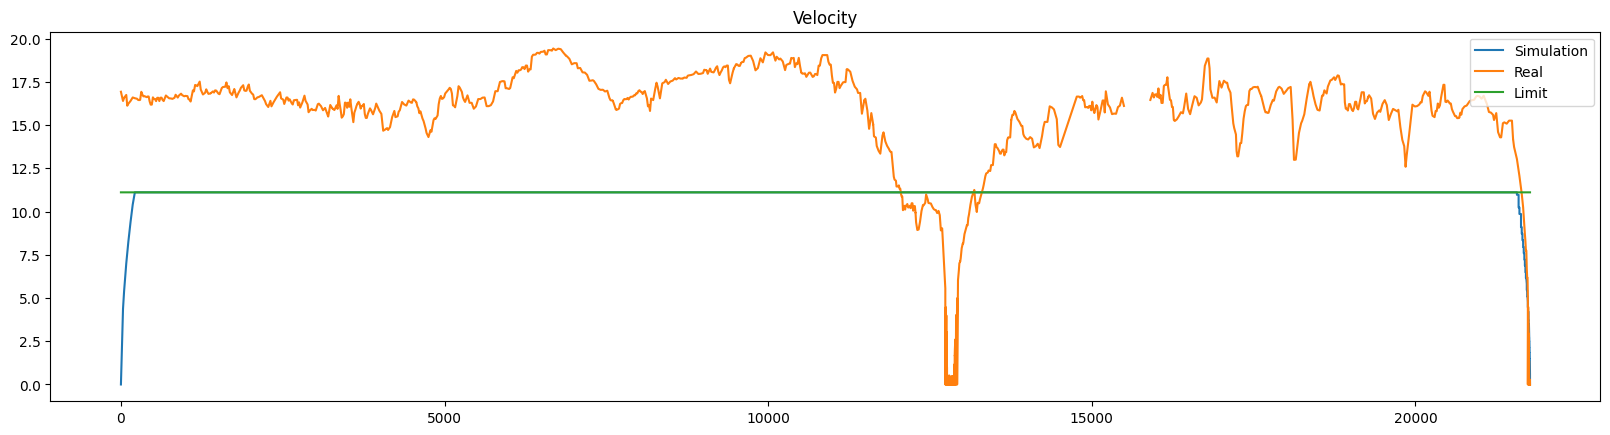

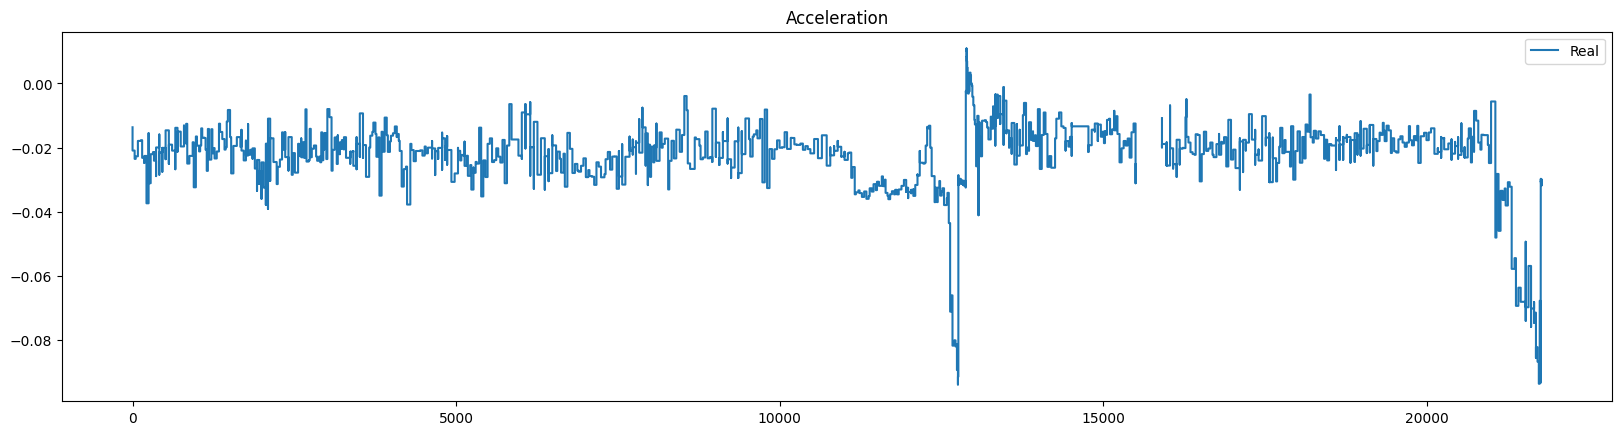

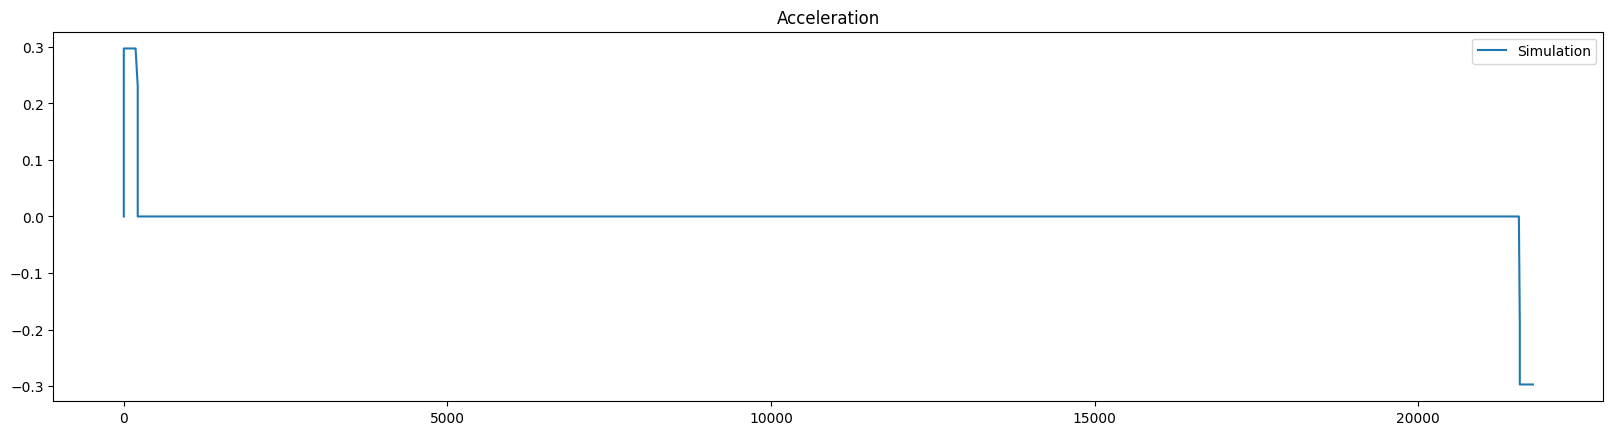

IndexError: tuple index out of range

In [15]:
importlib.reload(tconsumption)

compare_data(
    df_slice,
    "../testing-data/um7/um7capture_2023-09-29_06-26-06_krnov-krnov.geojson"
)

### Data z telefonu

In [ ]:
# df_phone = pd.read_csv("/tmp/Accelerometer.csv", delimiter=",")[0:10000]

# print(df_phone.shape[0])

# render_plot(
#     "Acceleration",
#     df_phone["time"],
#     [df_phone["x"]],
#     ["x"]
# )

# render_plot(
#     "Acceleration",
#     df_phone["time"],
#     [df_phone["y"]],
#     ["y"]
# )

# render_plot(
#     "Acceleration",
#     df_phone["time"],
#     [df_phone["z"]],
#     ["z"]
# )